In [58]:
import requests
from requests.compat import urljoin
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from augur.util import annotate
import json
import re
import pandas as pd
import seaborn as sns
from github import Github
import requests
import augur
import os
from augur.datasources.localcsv.localcsv import LocalCSV
from augur import logger
from augur.util import annotate


%matplotlib inline

In [41]:
github.bus_factor("bitcoin","bitcoin")

,best,worst
0,103,1


In [17]:
github.bus_factor("augurproject","augur")

,best,worst
0,53,1


In [42]:
github.bus_factor("ethereum","go-ethereum")

,best,worst
0,56,1


In [18]:
closed_issues = github.closed_issues("augurproject","augur")

,created_at,count
0,2019-06-11,2
1,2019-06-12,12
2,2019-06-13,8
3,2019-06-14,5
4,2019-06-17,3


In [22]:
code_commits = github.code_commits("augurproject","augur")

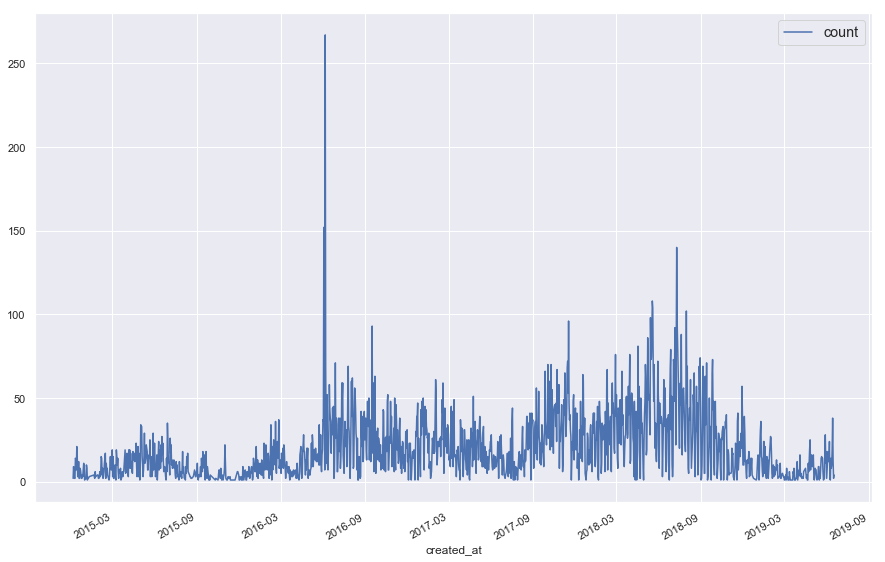

In [40]:
code_commits[['created_at','count']].set_index('created_at').plot()
sns.set(rc={'figure.figsize':(15,10)})
plt.legend(fontsize="large")

In [23]:
contributors = github.contributors("augurproject","augur")

In [24]:
contributors_gender = github.contributors_gender("augurproject","augur")

In [46]:
contributors_gender.gender.value_counts()

M    46
F     4
Name: gender, dtype: int64

In [ ]:
code_commits[['created_at','count']].set_index('created_at').plot()
sns.set(rc={'figure.figsize':(15,10)})
plt.legend(fontsize="large")

In [25]:
lines_changed = github.lines_of_code_changed("augurproject","augur")

In [28]:
open_issues = github.open_issues("augurproject","augur")

In [163]:
lines_changed.columns

Index(['additions', 'date', 'deletions', 'delta', 'total_lines'], dtype='object')

In [ ]:
code_reviews_df = code_reviews("augurproject","augur")

In [ ]:
code_reviews_df.num_reviews.describe()

In [29]:
code_reviews_df.head()

,createdAt,pullNum,state,num_reviews
0,2019-06-17T22:15:18Z,2505,open,0.0
1,2019-06-17T21:53:58Z,2504,open,0.0
2,2019-06-05T07:29:32Z,2342,open,0.0
3,2019-05-22T08:11:08Z,2231,open,0.0
4,2019-05-17T11:38:13Z,2194,open,0.0


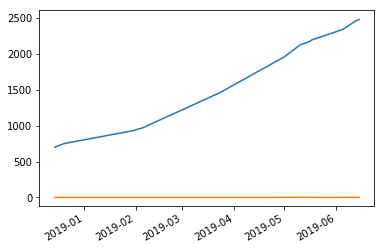

In [216]:
#lines_changed[['additions',  'deletions', 'delta', 'total_lines']].plot(figsize = (10,5))

# Convert to matplotlib's internal date format.
x =  mdates.datestr2num(code_reviews_df.createdAt)
y = code_reviews_df[['pullNum','num_reviews']]

fig, ax = plt.subplots()

ax.plot(x, y)
ax.xaxis_date()

# Optional. Just rotates x-ticklabels in this case.
fig.autofmt_xdate()

plt.show()

In [134]:
xdef lines_deleted(owner, repo=None): 
    """
    Additions and deletions each week

    :param owner: The name of the project owner
    :param repo: The name of the repo
    :return: DataFrame with each row being am issue
    """
    # get the data we need from the GitHub API
    # see <project_root>/augur/githubapi.py for examples using the GraphQL API
    url = "https://api.github.com/repos/{}/{}/stats/code_frequency".format(owner, repo)
    json = requests.get(url, auth=('user', key)).json()
    # get our data into a dataframe
    df = pd.DataFrame(json, columns=['date', 'additions', 'deletions'])
    # all timeseries metrics need a 'date' column
    df['date'] = pd.to_datetime(df['date'], unit='s', infer_datetime_format=True)
    # normalize our data
    df['deletions'] = df['deletions'] * -1
    # return the dataframe
    return df

In [135]:
lines_deleted_df = lines_deleted("augurproject","augur")

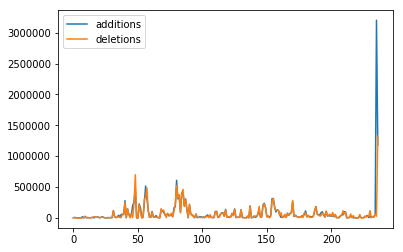

In [138]:
lines_deleted_df[["additions","deletions"]].plot()

In [140]:

import json
from perceval.backends.core.git import Git

# url for the git repo to analyze (uncomment the line you want to analyze)
#repo_url = 'http://github.com/chaoss/grimoirelab-perceval'
repo_url = 'https://github.com/augurproject/augur'
#repo_url = 'https://github.com/git/git.git'
# directory for letting Perceval clone the git repo (make sure it is empty)
repo_dir = '/tmp/git_repo'

# create a Git object, pointing to repo_url, using repo_dir for cloning
repo = Git(uri=repo_url, gitpath=repo_dir)

number = 0
with open('git-commits.json', 'w') as commits_file:
    # fetch all commits as an iterator, and dump them to a file, one per line
    for commit in repo.fetch():
        json.dump(commit, commits_file)
        commits_file.write('\n')
        number += 1
print("Commits read:", number)

2019-06-14 23:38:50 C02WV1SMJG5L perceval.backends.core.git[81755] INFO Fetching commits: 'https://github.com/augurproject/augur' git repository from 1970-01-01 00:00:00+00:00 to 2100-01-01 00:00:00+00:00; all branches
2019-06-14 23:41:34 C02WV1SMJG5L perceval.backends.core.git[81755] INFO Fetch process completed: 31307 commits fetched


Commits read: 31307


In [141]:
import json

commits = {}
with open('git-commits.json') as commits_file:
    for line in commits_file:
        commit = json.loads(line)
        commits[commit['data']['commit']] = commit
print("Total number of commits:", len(commits))

Total number of commits: 31307


In [142]:
code_commits = len(commits)
print("Code Commits (naive):", code_commits)

Code Commits (naive): 31307


In [143]:
code_commits = 0
for commit in commits.values():
    for file in commit['data']['files']:
        if 'action' in file:
            code_commits += 1
            break
                
print("Code Commits (non-empty):", code_commits)

Code Commits (non-empty): 26860


In [144]:
code_commits = 0
for commit in commits.values():
    if 'Merge' not in commit['data']:
        code_commits += 1
                
print("Code Commits (non-merge):", code_commits)

Code Commits (non-merge): 25693


In [145]:
# Find commits in master branch.
# Start by adding head to an empty todo list. Then loop until todo set is empty:
# for each commit in the todo list, add it to the master set, and go backwards
# (finding parents), adding them to the todo set.

todo = set()
for id, commit in commits.items():
    if 'HEAD -> refs/heads/master' in commit['data']['refs']:
        todo.add(id)

master = set()
while len(todo) > 0:
    current = todo.pop()
    master.add(current)
    for parent in commits[current]['data']['parents']:
        if parent not in master:
            todo.add(parent)
    
code_commits = len(master)
    
print("Code Commits (master branch):", code_commits)

Code Commits (master branch): 30941


In [146]:
code_commits = 0
for commit_id in master:
        commit = commits[commit_id]
        for file in commit['data']['files']:
            if 'action' in file:
                code_commits += 1
                break

print("Code Commits (non-empty in master branch):", code_commits)

Code Commits (non-empty in master branch): 26534


In [147]:
import datetime
import pandas as pd

commits_summary = []
for commit in commits.values():
    summary = {
        'hash': commit['data']['commit'],
        'author': commit['data']['Author'],
        'author_date': datetime.datetime.strptime(commit['data']['AuthorDate'],
                                                "%a %b %d %H:%M:%S %Y %z"),
        'commit': commit['data']['Commit'],
        'commit_date': datetime.datetime.strptime(commit['data']['CommitDate'],
                                                "%a %b %d %H:%M:%S %Y %z"),
        'files_no': len(commit['data']['files'])
    }
    actions = 0
    for file in commit['data']['files']:
        if 'action' in file:
            actions += 1
    summary['files_action'] = actions
    if 'Merge' in commit['data']:
        summary['merge'] = True
    else:
        summary['merge'] = False
    if commit['data']['commit'] in master:
        summary['master'] = True
    else:
        summary['master'] = False        
    commits_summary.append(summary)

    commits_df = pd.DataFrame(commits_summary)
    commits_df['author_date'] = pd.to_datetime(commits_df['author_date'], utc=True)
    commits_df['commit_date'] = pd.to_datetime(commits_df['commit_date'], utc=True)

In [148]:
print("Total number of commits:", len(commits_df.index))

print("Code Commits (naive):", len(commits_df.index))

print("Code Commits (non-empty):", len(commits_df[commits_df['files_action']>0].index))

print("Code Commits (non-merge):", len(commits_df[commits_df['merge']==False].index))

print("Code Commits (master branch):", len(commits_df[commits_df['master']==True].index))

print("Code Commits (non-empty in master branch):",
     len(commits_df[(commits_df['files_action']>0) & (commits_df['master']==True)].index))

Total number of commits: 31307
Code Commits (naive): 31307
Code Commits (non-empty): 26860
Code Commits (non-merge): 25693
Code Commits (master branch): 30941
Code Commits (non-empty in master branch): 26534


In [149]:
by_month = commits_df['author_date'] \
    .groupby([commits_df.author_date.dt.year.rename('year'),
              commits_df.author_date.dt.month.rename('month')]) \
    .agg('count')
by_month

year  month
2014  12        159
2015  1          58
      2         188
      3         200
      4         348
      5         462
      6         385
      7         269
      8         145
      9         191
      10         59
      11         77
      12        115
2016  1         293
      2         431
      3         250
      4         296
      5         451
      6        1309
      7         809
      8         815
      9         868
      10        679
      11        603
      12        559
2017  1         755
      2         790
      3         578
      4         547
      5         574
      6         391
      7         273
      8         629
      9         781
      10       1255
      11       1132
      12        708
2018  1         767
      2         974
      3        1097
      4         863
      5        1658
      6         992
      7        1681
      8        1083
      9         875
      10        661
      11        459
      12        259
2019  1 

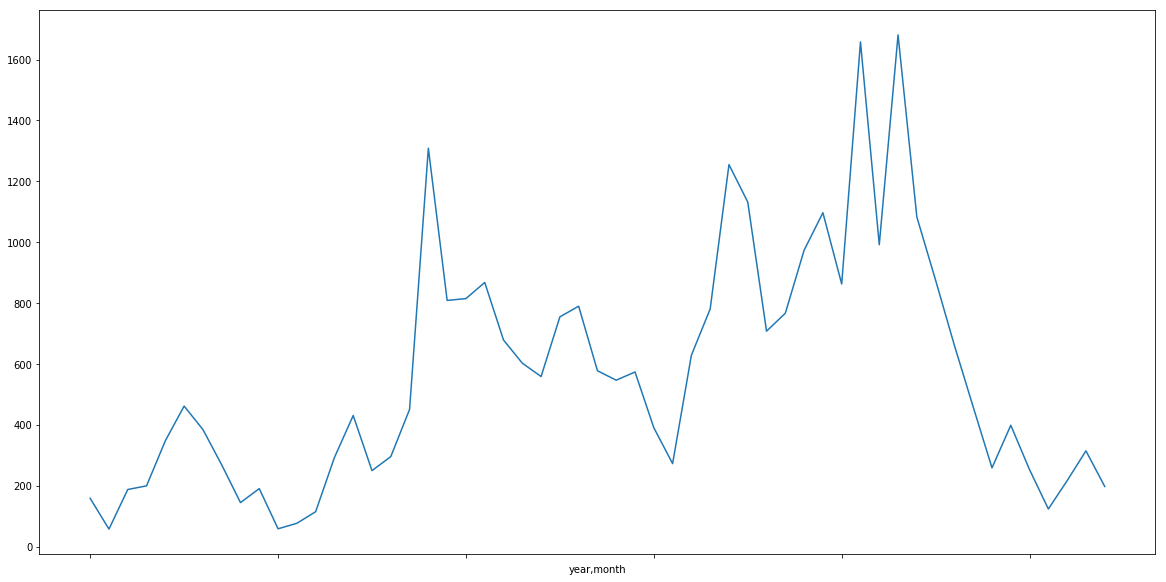

In [157]:
by_month.plot(figsize=(20,10))